**Episodic Semi-Gradient Sarsa + Tile Coding for Discrete Mountain Car**

https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/1001_Episodic_Semi_Gradient_Sarsa.html


Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
import gym
#from helpers_1001 import eval_state_action_space, plot_q_max_3d
#import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

**Custom_MountainCarEnv + ElectricalDCMotorEnv**

In [ ]:

"""
http://incompleteideas.net/MountainCar/MountainCar1.cp
permalink: https://perma.cc/6Z2N-PFWC
"""
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class Custom_MountainCarEnv(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with discrete actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation             | Value | Unit         |
    |-----|-------------------------|-------|--------------|
    | 0   | Accelerate to the left  | Inf   | position (m) |
    | 1   | Don't accelerate        | Inf   | position (m) |
    | 2   | Accelerate to the right | Inf   | position (m) |
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) * force - cos(3 * position<sub>t</sub>) * gravity*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
    upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
    velocity is clipped to the range `[-0.07, 0.07]`.
    ### Reward:
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
    penalised with a reward of -1 for each timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in *[-0.6 , -0.4]*.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 200.
    ### Arguments
    ```
    gym.make('MountainCar-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.one_over_mass = 0.001 # mass in kg, replaces 1/self.force
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

                ### Customization changes ######
        self.tau = 1.0 # seconds between state updates
        self.MRAC = ModelRefAC()
        self.NumIntegrationsSteps = 200
        self.tau1 =self.tau/self.NumIntegrationsSteps #.05 # integration time sample
        self.MRAC.timeSample = self.tau1
        self.MRAC.plant.tau1 = self.tau1
        self.MRAC.ref_model.tau1 = self.tau1
        ####
        self.wanted_force = 0.0


    def step(self, action: int):
        assert self.action_space.contains( action ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        wanted_force = (action - 1) # wanted forces in Newton = {-1,0,+1}[N]
        self.wanted_force=wanted_force
        for n in np.arange(start=0, stop=self.NumIntegrationsSteps, step=1):
          #generates actual force
          self.MRAC.plant.thetadot = velocity
          actual_force = self.MRAC.step(r=wanted_force)
          #actual_force = wanted_force # change for perfect applying force

          velocity += (actual_force * self.one_over_mass - self.gravity * math.cos(3 * position))*self.tau1
          if velocity > self.max_speed:
              velocity = self.max_speed
          if velocity < -self.max_speed:
              velocity = -self.max_speed
          position += (velocity)*self.tau1
          if position > self.max_position:
              position = self.max_position
          if position < self.min_position:
              position = self.min_position
          if position == self.min_position and velocity < 0:
              velocity = 0

        terminated = bool(
            position >= self.goal_position #and velocity >= self.goal_velocity
        )
        reward = -1.0

        self.state = (position, velocity)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False ,wanted_force , actual_force

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        ### reset DC motor init. conditions
        self.MRAC.reset()
        self.MRAC.plant.reset()
        self.MRAC.ref_model.reset()

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ElectricalDCMotorEnv():

  def __init__(self):
    self.Resistor_R = 1.0
    self.inductor_L = 0.1
    self.torque_const_Kt = 1.0
    self.bemf_const_Ke = 1.0
    self.tau1 = 0.05
        #
    self.current = 0.0
    self.voltage_input = None
    self.thetadot = 0.0

  def step(self, u):
    voltage_BEMF = self.thetadot*self.bemf_const_Ke
    self.voltage_input = np.clip(u, -10, 10)

    f1 = self.torque_const_Kt*self.current+0.1*np.random.standard_normal()
    self.current += self.tau1*(self.voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
    f2 = self.torque_const_Kt*self.current
    F = f2
    return F # return actual applied torque

  def reset(self):
    self.current = 0.0

In [ ]:
class ReferenceModel():

  def __init__(self):
    self.a_m = 50.0#30.0
    self.b_m = self.a_m
    self.tau1 = 0.05
    self.x_m = 0.0
    self.y_m = 0.0

  def step(self, r):

    #fwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #self.y_m = self.x_m+0
    #self.x_m = (1+A)*self.y_m+Br
    #y_m = self.y_m+0

    #bkwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #if A ==1:
    #  C=1
    #else:
    #  C = 1/(1-A)
    #self.y_m = C*(self.x_m-Br)
    #self.x_m = self.y_m+0
    #y_m = self.y_m+0

    #trapz integragration
    A = -0.5*self.a_m*self.tau1
    Br= +0.5*self.b_m*self.tau1*r
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    x_m = self.x_m
    y_m = C*(x_m+Br)
    x_m = (1+A)*y_m + Br
    self.x_m = x_m
    self.y_m = y_m

    return y_m

  def reset(self):
    self.x_m = 0.0
    self.y_m = 0.0

In [ ]:
class ModelRefAC:

  def __init__(self): #  order of signals [r,y,r-y,w]
    self.plant = ElectricalDCMotorEnv()
    self.ref_model = ReferenceModel()
    self.w = 0.0
    self.u = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0
    self.adaptation_gain=np.array([50,60,10,50])*14 # positive scalar or np.array shape (4,)
    self.sigma_mod_adapt_gain=0 # non-neg scalar or np.array shape (4,)
    self.emod_adapt_gain=0
    self.dead_zone_threshold = 0*1e-5
    self.dead_zone_adapt_gain = 0*1e-3
    self.timeSample=0.05
    self.mu0 = np.array([1e-3,-1e-3,1e-3,1e-3])
    self.std = 0*1e-6
    self.k_temp = self.mu0
    self.k_hat =  self.mu0
    self.keep_coeff = True
    self.mask = np.array([True,True,True,True])
    self.distrib = np.random.standard_normal


  def step(self, r):
    self.r = r
    self.w = self.plant.thetadot
    y = self.y
    y_m = self.y_m
    e=y-y_m
    u = self.adaptationControlLaw(e=e, r=r, y=y, w=self.w)
    self.y_m = self.ref_model.step(r)
    self.y = self.plant.step(u)
    return self.y

  def adaptationControlLaw(self, e, r, y, w):
    v = np.array([r,y,r-y,w])#.clip(-20,20)
    e_norm = abs(e)

    #fwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #self.k_hat = self.k_temp*self.mask
    #self.k_temp = ((1+A)*self.k_hat + Bev)*self.mask

    #backwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #C = 1-A*(A!=np.ones_like(A))
    #C = 1/C
    #self.k_hat = C*(self.k_temp+Bev)*self.mask
    #self.k_temp = A*self.k_hat*self.mask

    #trapz integration
    A = -0.5*(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    Bev = -0.5*self.adaptation_gain*self.timeSample*e*v
    if e_norm<=self.dead_zone_threshold:
      A = A*self.dead_zone_adapt_gain
      Bev = Bev*self.dead_zone_adapt_gain
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    self.k_hat = C*((self.k_temp +Bev)*self.mask)
    self.k_temp = ((1+A)*self.k_hat +Bev)*self.mask
    u = np.dot(v,self.k_hat)
    u=np.clip(u,-10,10)
    self.u = u
    return u

  def reset(self):
    self.w = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0
    mu0 = self.mu0
    sigma0 = self.std
    keep_coeff = self.keep_coeff
    self.k_temp = (sigma0*self.distrib(self.k_temp.shape) + keep_coeff*self.k_temp + (not keep_coeff)*mu0)*self.mask
    self.k_hat = (sigma0*self.distrib(self.k_hat.shape) + keep_coeff*self.k_hat + (not keep_coeff)*mu0)*self.mask


In [ ]:
env =  Custom_MountainCarEnv()

In [ ]:
print("dt= ", env.tau)
print("N= ", env.NumIntegrationsSteps)
print("dt/N=", env.tau/env.NumIntegrationsSteps)
print("gamma*dt/N=", env.MRAC.adaptation_gain*env.tau/env.NumIntegrationsSteps)

dt=  1.0
N=  200
dt/N= 0.005
gamma*dt/N= [3.5 4.2 0.7 3.5]


Episodic Semi-Gradient Sarsa

In [ ]:
plotting_rewards=[]
ploting_adapt_coeff=[]

save_observation = []
save_wanted_force = [0]
save_actual_force = [0]
save_model_force = [0]
save_ctrl_voltage = []
save_MRAC_adapt_gains = []

In [ ]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, q_hat, callback=None, trace=None, train_mode=True):
    """Episodic Semi-Gradient Sarsa

    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            act_space = range(env.action_space.n)
            q_values = [q_hat.eval(st,a) for a in act_space]
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.action_space.n)

    # skip weight intialization,
    initial_not_saved = True
    print('Initial adapt. coeffs: ', env.MRAC.mu0)
    for e_ in range(ep):
        S, infor = env.reset()
        A = policy(S, q_hat, eps)
        score = 0
        for t_ in range(10**100):
            #
            k_hat_print = env.MRAC.k_hat.round(2)
            if e_ == ep-1 and initial_not_saved:
              save_MRAC_adapt_gains.append(env.MRAC.k_hat)
              save_observation.append(S)
              u0=env.MRAC.adaptationControlLaw(e=env.MRAC.y-env.MRAC.y_m,
                                              r=env.MRAC.r,y=env.MRAC.y,
                                              w=env.MRAC.w)
              save_ctrl_voltage.append(u0)
              initial_not_saved = False
            #
            infor = env.step(A)
            S_= infor[0]
            R = infor[1]
            done = infor[2]
            wanted_force=infor[4]
            actual_force=infor[5]
            ##
            if e_ == ep-1:
              save_observation.append(S_)
              save_wanted_force.append(wanted_force)
              save_actual_force.append(actual_force)
              save_model_force.append(env.MRAC.y_m)
              save_ctrl_voltage.append(env.MRAC.u)
              save_MRAC_adapt_gains.append(env.MRAC.k_hat)
             #end if
            score += R
            if done:
                q_hat.train(S, A, R)
                break
            A_ = policy(S_, q_hat, eps)
            target = R + gamma * q_hat.eval(S_, A_)

            if train_mode: #### add boolian cond. for train mode
              q_hat.train(S, A, target)

            S, A = S_, A_

            if callback is not None:
                callback(e_, t_, q_hat, trace)
        ploting_adapt_coeff.append(k_hat_print)
        plotting_rewards.append(score)
        print(f"EPISODE: {e_ + 1}, ", "adapt. coeffs at final time step: ", k_hat_print)
        if (e_ + 1)%10==0 and e_>0:
          k_hat_median = np.median(np.array(ploting_adapt_coeff), axis=0)
          print("median: ", k_hat_median)
        print(f"EPISODE: {e_ + 1} - FINAL SCORE: {score} ") # Print the final score

Tile Coding

In [ ]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low      - state space low boundry in all dim, e.g. [-1.2, -0.07] for mountain car
            st_high     - state space high boundry in all dimensions
            nb_actions  - number of possible actions
            learn_rate  - step size, will be adjusted for nb_tilings automatically
            num_tilings - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val    - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)

        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * nb_actions

        self._iht = IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings

    def eval(self, state, action):
        #assert len(state) == self._n_dim
        #assert np.isscalar(action)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        return np.sum(self._weights[active_tiles])       # pick correct weights and sum up

    def train(self, state, action, target):
        #assert len(state) == self._n_dim
        #assert np.isscalar(action)
        #assert np.isscalar(target)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
        delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
        self._weights[active_tiles] += delta             # ..so we pick active weights instead

In [ ]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed.
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)),
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile
coordinates are to be returned without being converted to indices).

Documentation : http://incompleteideas.net/tiles/tiles3.html
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrawidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        #for q, width in zip_longest(qfloats, wrapwidths):
        for q, width in zip_longest(qfloats, wrawidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

def plot_q_max_3d(q_arr, env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe

    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = -1 * np.max(q_arr, axis=-1)  # calc max and inverse

    x_min, x_max = env.low[0], env.high[0]
    y_min, y_max = env.low[1], env.high[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)

    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)

    axis.view_init(40, -70)



def eval_state_action_space(q_hat, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array

    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.low[0], env.high[0]
    y_min, y_max = env.low[1], env.high[1]
    x_split, y_split = split

    q_arr = np.zeros([x_split, y_split, env.action_space.n])
    act_space = range(env.action_space.n)
    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            for act in act_space:
                q_arr[pi, vi, act] = q_hat.eval(state=[pos, vel], action=act)

    return q_arr

Helper functions

In [ ]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [ ]:
def callback(episode, tstep, model, trace):
    """Called from gradient_MC after every episode.

    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    episodes = [1, 12, 104, 1000, 9000]
    if episode in episodes and tstep == 0:
        q_arr = eval_state_action_space(q_hat, env)
        trace.append(q_arr)

Solve Mountain Car

In [ ]:
env =  Custom_MountainCarEnv()

In [ ]:
print(env.action_space.n)

3


In [ ]:
q_hat = TileCodingFuncApprox(env.low, env.high, env.action_space.n,
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=600, gamma=1.0, eps=0.0, q_hat=q_hat)

Initial adapt. coeffs:  [ 0.001 -0.001  0.001  0.001]
EPISODE: 1,  adapt. coeffs at final time step:  [ 3.69 -2.69  1.19  0.96]
EPISODE: 1 - FINAL SCORE: -2432.0 
EPISODE: 2,  adapt. coeffs at final time step:  [ 3.65 -1.75  1.02  1.03]
EPISODE: 2 - FINAL SCORE: -929.0 
EPISODE: 3,  adapt. coeffs at final time step:  [ 3.8  -2.8   1.23  0.97]
EPISODE: 3 - FINAL SCORE: -507.0 
EPISODE: 4,  adapt. coeffs at final time step:  [ 3.68 -1.75  1.03  0.99]
EPISODE: 4 - FINAL SCORE: -848.0 
EPISODE: 5,  adapt. coeffs at final time step:  [ 3.31 -2.15  1.02  1.02]
EPISODE: 5 - FINAL SCORE: -437.0 
EPISODE: 6,  adapt. coeffs at final time step:  [ 3.32 -2.32  1.05  1.03]
EPISODE: 6 - FINAL SCORE: -722.0 
EPISODE: 7,  adapt. coeffs at final time step:  [ 3.29 -1.84  0.97  1.  ]
EPISODE: 7 - FINAL SCORE: -379.0 
EPISODE: 8,  adapt. coeffs at final time step:  [ 3.37 -1.81  0.98  0.98]
EPISODE: 8 - FINAL SCORE: -632.0 
EPISODE: 9,  adapt. coeffs at final time step:  [ 3.41 -2.32  1.07  1.  ]
EPISODE

In [ ]:
print("=====")
print("mean: ", (np.array(ploting_adapt_coeff)).mean(axis=0).round(2))
print("median: ", np.median(np.array(ploting_adapt_coeff), axis=0))

=====
mean:  [ 3.69 -2.67  1.18  0.99]
median:  [ 3.8  -2.8   1.23  0.99]


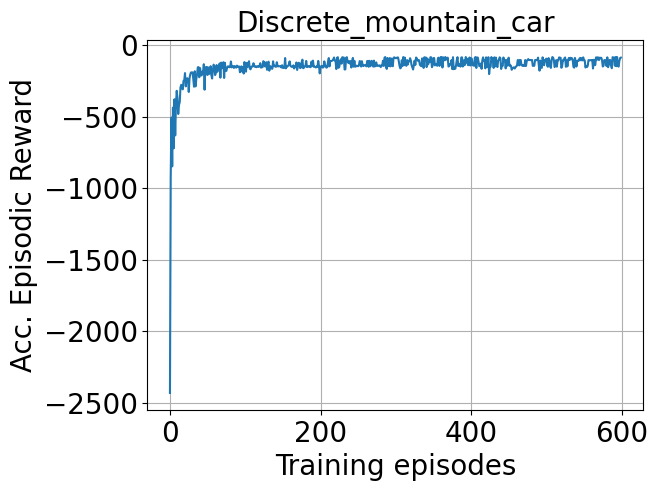

In [ ]:
import matplotlib.pyplot as plt

font = {'size': 20}
plt.rc('font', **font)
plt.plot(plotting_rewards)
plt.xlabel('Training episodes',fontsize=20)
plt.ylabel('Acc. Episodic Reward',fontsize=20)
#plt.rc('axes', labelsize=30)

plt.grid()
#plt.legend()
plt.title('Discrete_mountain_car',fontsize=20)
plt.show()

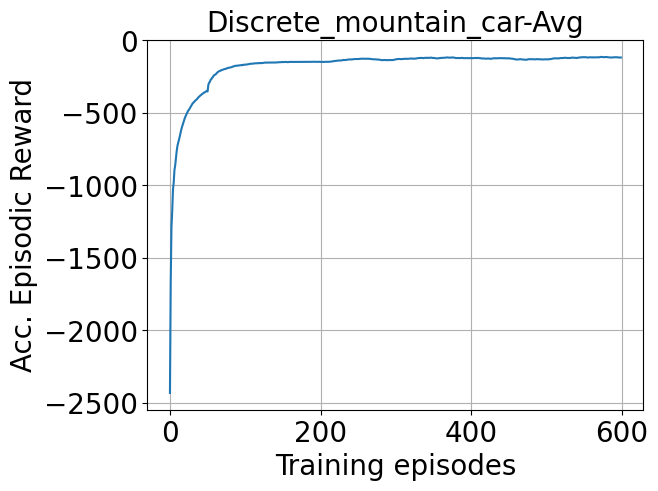

In [ ]:
N=50
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(plotting_rewards):
    if i < N:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(plotting_rewards[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(plotting_rewards[i-N:i+1]) / N
    moving_average.append(avg)

# Plot the moving average
plt.plot(moving_average)
plt.xlabel('Training episodes',fontsize=20)
plt.ylabel('Acc. Episodic Reward',fontsize=20)

plt.grid()
#plt.legend()
plt.title('Discrete_mountain_car-Avg',fontsize=20)
plt.show()

In [ ]:
print("Last avg of", N, "Episodes = ", avg)

Last avg of 50 Episodes =  -117.62


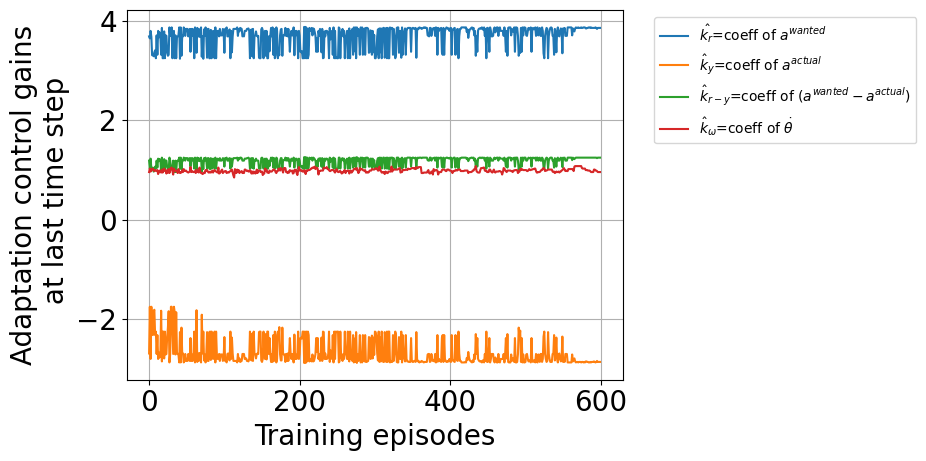

In [ ]:
font = {'size': 20}
plt.rc('font', **font)
plt.plot(ploting_adapt_coeff)
plt.xlabel("Training episodes")
plt.ylabel("Adaptation control gains\n at last time step")
#plt.rc('axes', labelsize=30)

plt.grid()
plt.legend(labels=[r"$\hat{k_r}$=coeff of $a^{wanted}$",
                   r"$\hat{k}_y$=coeff of $a^{actual}$",
                 r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$",
                 r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"], fontsize=10,
           bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
#ploting_adapt_coeff = np.array(ploting_adapt_coeff)

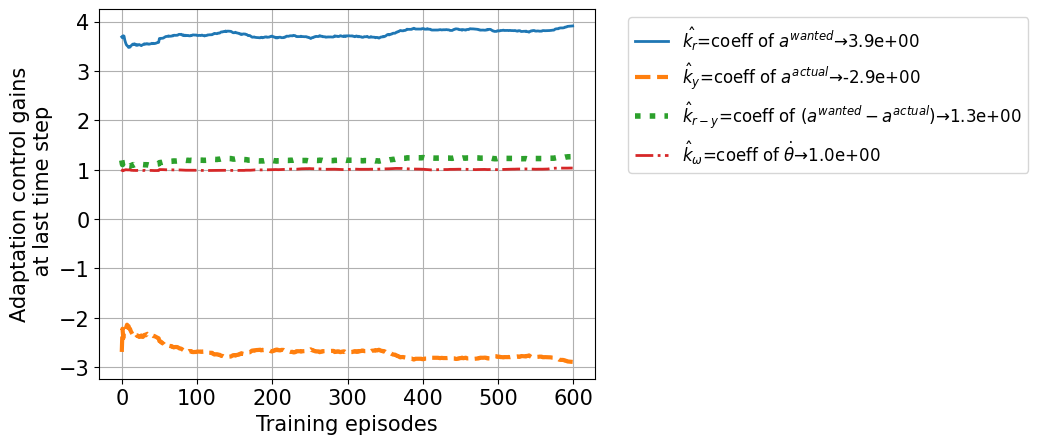

In [ ]:
N=50
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(ploting_adapt_coeff):
    if i < N:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(ploting_adapt_coeff[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(ploting_adapt_coeff[i-N:i+1]) / N
    moving_average.append(avg)
moving_average = np.array(moving_average).T
# Plot the moving average

plt.plot(moving_average[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{moving_average[0,-20:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(moving_average[1],'--',
         label = r"$\hat{k}_y$=coeff of $a^{actual}$"+f"→{moving_average[1,-20:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(moving_average[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{moving_average[2,-20:-1].mean():.1e}",color="C2",linewidth = 4)
plt.plot(moving_average[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{moving_average[3,-20:-1].mean():.1e}",color="C3",linewidth = 2)
#plt.plot(moving_average)
plt.xlabel("Training episodes")
plt.ylabel("Adaptation control gains\n at last time step")
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
dt=env.tau

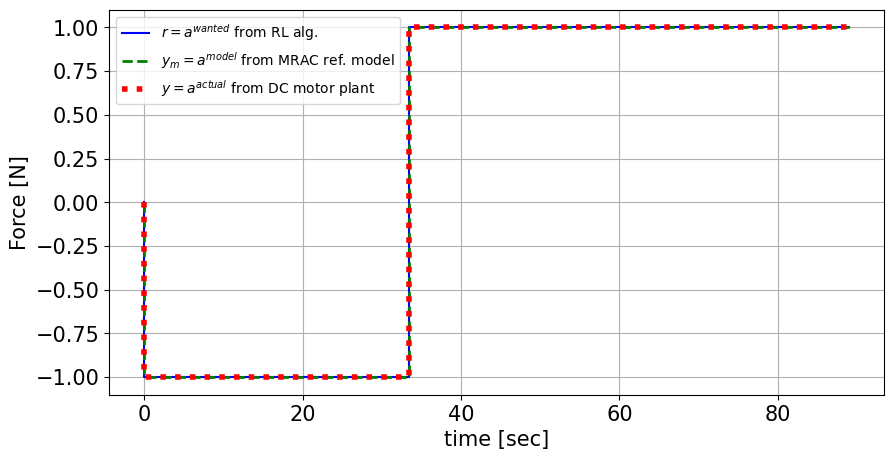

In [ ]:
time_ = np.linspace(start = 0, stop = len(save_actual_force)* dt,num=len(save_actual_force) )

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


plt.step(time_, save_wanted_force ,label = r"$r=a^{wanted}$ from RL alg.",color="blue",linewidth = 1.5)
plt.step(time_, save_model_force , '--',label = "$y_m=a^{model}$ from MRAC ref. model",color="green",linewidth = 2)
plt.step(time_, save_actual_force , ':',label = "$y=a^{actual}$ from DC motor plant",color="red",linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Force [N]")
plt.legend(fontsize=10)
plt.grid()
plt.show()

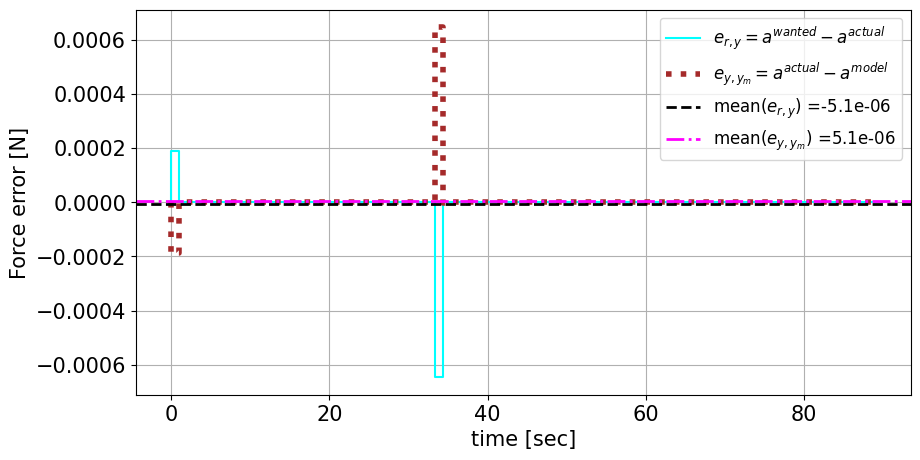

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_force)-np.array(save_actual_force)
e_yy_m=np.array(save_actual_force)-np.array(save_model_force)


plt.step(time_, e_ry ,label = "$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)
plt.axhline(y=e_ry.mean(), color="black",linewidth = 2, linestyle='--', label='mean($e_{r,y}$) =' +f'{e_ry.mean():.1e}')
plt.axhline(y=e_yy_m.mean(), color="magenta",linewidth = 2, linestyle='-.', label='mean($e_{y,y_m}$) =' +f'{e_yy_m.mean():.1e}')


plt.xlabel("time [sec]")
plt.ylabel("Force error [N]")
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
from scipy.integrate import cumulative_trapezoid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


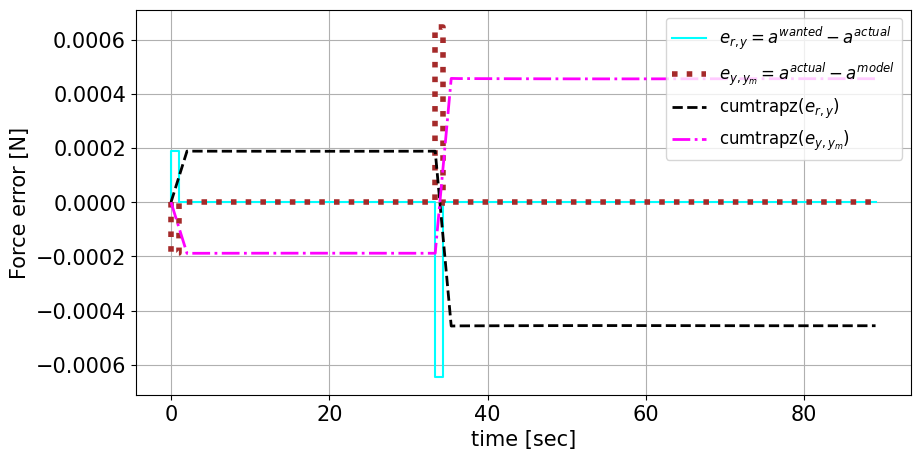

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_force)-np.array(save_actual_force)
e_yy_m=np.array(save_actual_force)-np.array(save_model_force)

cum_trapz_e_ry = cumulative_trapezoid(y=np.r_[0,e_ry],x=None, dx=dt)
cum_trapz_e_yy_m = cumulative_trapezoid(y=np.r_[0,e_yy_m],x=None, dx=dt)


plt.step(time_, e_ry ,label = r"$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)

plt.plot(time_, cum_trapz_e_ry,'--',
         label = r"cumtrapz($e_{r,y}$)",color="black",linewidth = 2)
plt.plot(time_, cum_trapz_e_yy_m,'-.',
         label = r"cumtrapz($e_{y,y_m}$)",color="magenta",linewidth = 2)

plt.xlabel("time [sec]")
plt.ylabel("Force error [N]")
plt.legend(fontsize=12)
plt.grid()
plt.show()

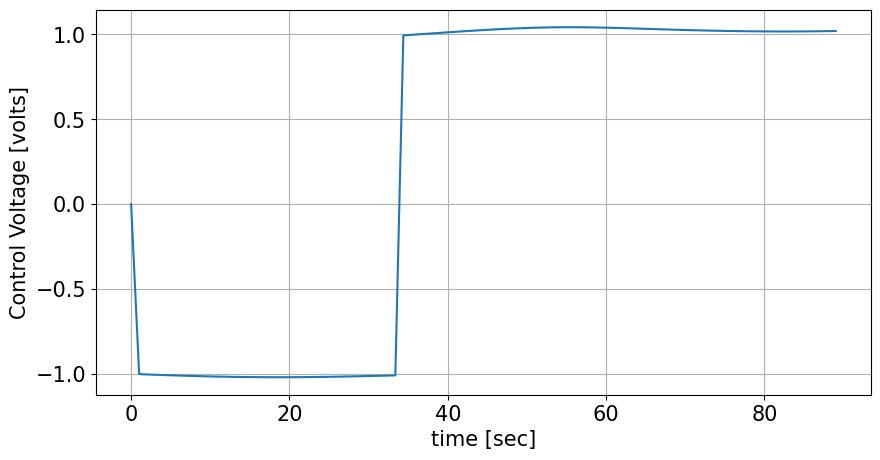

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(time_, save_ctrl_voltage)
plt.xlabel("time [sec]")
plt.ylabel("Control Voltage [volts]")
plt.grid()
plt.show()

In [ ]:
np_array_MRAC_adapt_gains = np.array(save_MRAC_adapt_gains).T

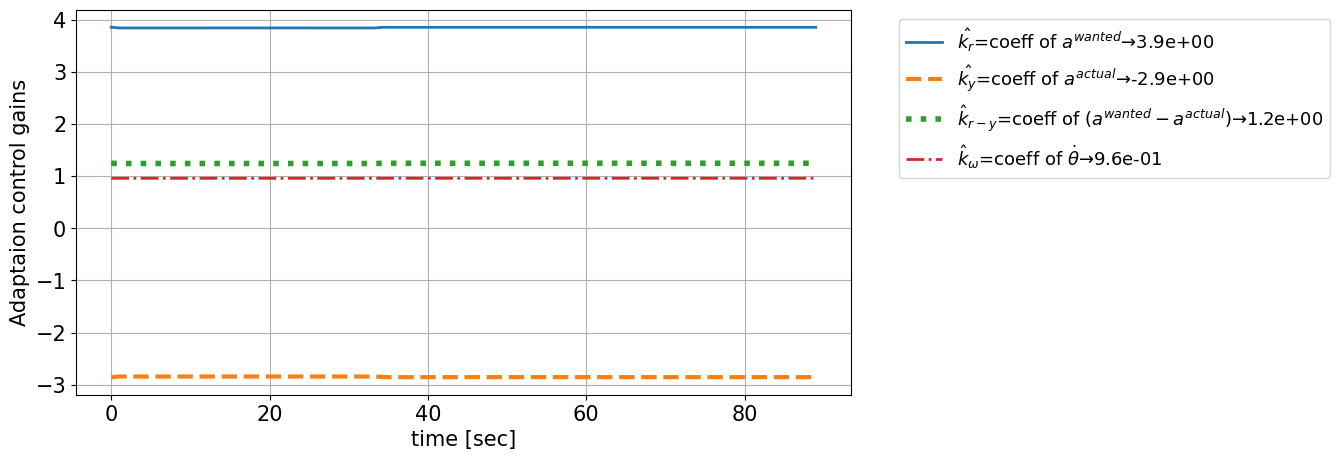

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

#plt.ylabel(r'$\dot{\theta}$ [rad/sec]')

plt.plot(time_, np_array_MRAC_adapt_gains[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{np_array_MRAC_adapt_gains[0,-20:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(time_, np_array_MRAC_adapt_gains[1],'--'
         ,label = r"$\hat{k_y}$=coeff of $a^{actual}$"+f"→{np_array_MRAC_adapt_gains[1,-20:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(time_, np_array_MRAC_adapt_gains[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{np_array_MRAC_adapt_gains[2,-20:-1].mean():.1e}",color="C2",linewidth = 4)
plt.plot(time_, np_array_MRAC_adapt_gains[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{np_array_MRAC_adapt_gains[3,-20:-1].mean():.1e}",color="C3",linewidth = 2)
plt.xlabel("time [sec]")
plt.ylabel("Adaptaion control gains")
plt.grid()
plt.legend(fontsize=13, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()



In [ ]:
import math

position_print = []
velocity_print = []


for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position_print.append(value)

    if index == 1:
      velocity_print.append(value)


In [ ]:
print(len(position_print))

89


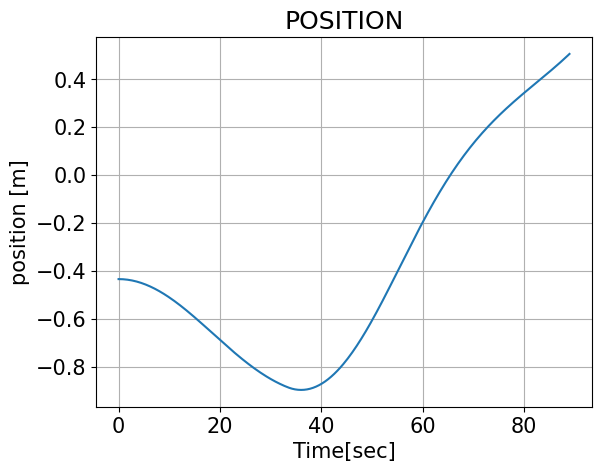

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_position_print = np.linspace(start = 0, stop = len(position_print)*dt,num=len(position_print))##############################################
#time_position , position
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_position_print[-1] , 300)

spl = make_interp_spline(time_position_print, position_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.ylabel('position [m]')
plt.xlabel('Time[sec]')
plt.grid()
#plt.legend()
plt.title('POSITION')
plt.show()

In [ ]:
print("Car reached to goal afer "+str(time_position_print[-1])+ " seconds")

Car reached to goal afer 89.0 seconds


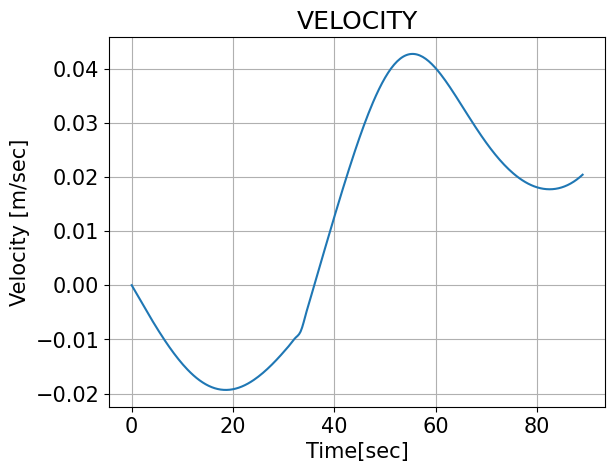

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_velocity_print = np.linspace(start = 0, stop = len(velocity_print)* dt,num=len(velocity_print))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity_print[-1] , 300)

spl = make_interp_spline(time_velocity_print, velocity_print, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.ylabel('Velocity [m/sec]')
plt.xlabel('Time[sec]')
plt.grid()
plt.title('VELOCITY')
plt.show()

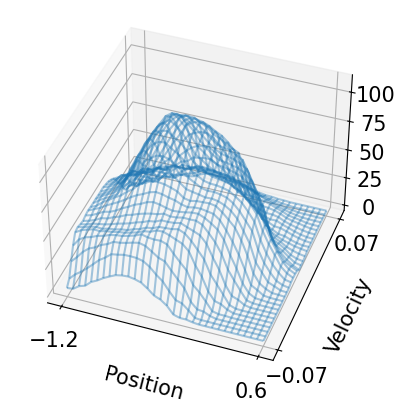

In [ ]:
q_arr = eval_state_action_space(q_hat, env)
plot_q_max_3d(q_arr, env, labels=['Position', 'Velocity', ''], alpha=0.4)